# INTRO

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install scikit-plot

from collections import defaultdict


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

In [6]:
class_name = 'Occupancy'

dataset_path="/content/drive/Shared drives/DM2/files/combined2.csv"
df = pd.read_csv(dataset_path)

df.head()

del df['Hour']
del df['Date']
del df['Day']

#del df['Temperature']
#del df['Humidity']
#del df['Light']
#del df['CO2']
#del df['HumidityRatio']


df.loc[df["Occupancy"] == 1, "Occupancy"] = 'Yes'
df.loc[df["Occupancy"] == 0, "Occupancy"] = 'No'




df.head()

,TimeSlot,Weekend,WorkingHour,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2,0,1,15.904468,8.698835,7.516689,5.235582,10.795786,Yes
1,2,0,1,15.957720,8.711492,7.452585,5.343291,10.831549,Yes
2,2,0,1,15.993220,8.669303,7.398537,5.432407,10.799950,Yes
3,2,0,1,15.971032,8.595474,6.654588,5.481292,10.709977,Yes
4,2,0,1,16.064222,8.648209,6.606039,5.522164,10.806016,Yes


Rimuovo dal dataset i campi Hour e Date, in quanto poco utili alla classificazione non essendo continui o discreti. 

In [0]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [8]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res

df.loc[df["Occupancy"] == 1, "Occupancy"] = 'Yes'
df.loc[df["Occupancy"] == 0, "Occupancy"] = 'No'

df.head()

,TimeSlot,Weekend,WorkingHour,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2,0,1,15.904468,8.698835,7.516689,5.235582,10.795786,Yes
1,2,0,1,15.957720,8.711492,7.452585,5.343291,10.831549,Yes
2,2,0,1,15.993220,8.669303,7.398537,5.432407,10.799950,Yes
3,2,0,1,15.971032,8.595474,6.654588,5.481292,10.709977,Yes
4,2,0,1,16.064222,8.648209,6.606039,5.522164,10.806016,Yes


# DECISION TREE

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

attributes = [col for col in df.columns if col != 'Occupancy']
X = df[attributes].values
y = df['Occupancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.4, 
                                                    random_state=100, 
                                                    stratify=y)

X_train.shape, X_test.shape

((12336, 8), (8224, 8))

In [10]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=2, 
                             min_samples_split=100, min_samples_leaf=4)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [11]:
for col, imp in zip(attributes, clf.feature_importances_):
    print(col, imp)

TimeSlot 0.0
Weekend 0.0
WorkingHour 0.0
Temperature 0.0
Humidity 0.0
Light 0.9972288994475823
CO2 0.0027711005524177048
HumidityRatio 0.0


1- stampo l'importanza assegnata ad ogni feature dopo l'adattamento del modello ai dati disponibili. si nota come la feature light venga considerata di gran lunga la più importante dall'albero di decisione. dato confermato dalla matrice delle associazioni, dove la feature light ha un grado elevatissimo di dipendenza con la classe Occupancy.

2- rimuovendo il campo light dal dataset, invece, è possibile notare come le features con più importanza siano working hour e weekend, in quanto com'è possibile notare dal decision tree prodotto in tal caso, le scelte principali vertono proprio sul valore binario di questi due campi, generando un modello dallep prestazioni comunque accettabili. ciò rivela come la generazione dei due campi dai dati iniziali abbia avuto un effettivo riscontro nella comprensione del fenomeno proposto dal dataset. 

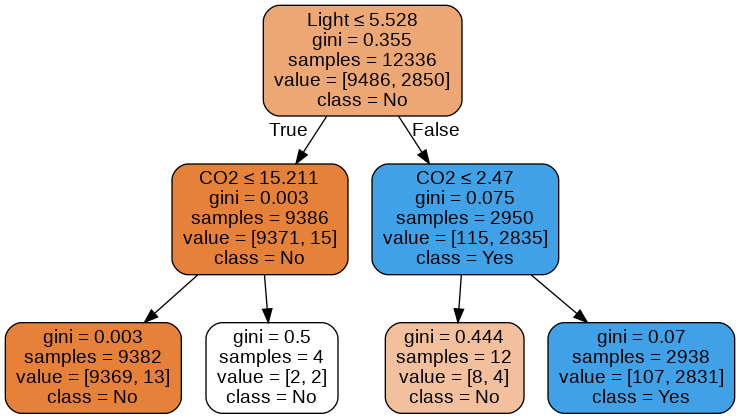

In [12]:
import pydotplus
from sklearn import tree
from IPython.display import Image


dot_data = tree.export_graphviz(clf, out_file=None,  
                                feature_names=attributes, 
                                class_names=clf.classes_,  
                                filled=True, rounded=True,  
                                special_characters=True
                                )  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

1- albero di decisione ottenuto profondo e complesso, modello costoso e poco comprensibile. 

2- albero di decisione ottenuto utilizzando i parametri ottimali ottenuti da grid search e random search. albero piccolo ma dall'accuratezza di 0.99 

In [13]:
y_pred = clf.predict(X_train)

print('Accuracy %s' % accuracy_score(y_train, y_pred))
print('F1-score %s' % f1_score(y_train, y_pred, average=None))
print('   ')

print('Classification Report: ')
print(classification_report(y_train, y_pred))

print('   ')
print('Confusion Matrix: ')
confusion_matrix(y_train, y_pred)

Accuracy 0.9897859922178989
F1-score [0.99332768 0.97823082]
   
Classification Report: 
              precision    recall  f1-score   support

          No       1.00      0.99      0.99      9486
         Yes       0.96      0.99      0.98      2850

    accuracy                           0.99     12336
   macro avg       0.98      0.99      0.99     12336
weighted avg       0.99      0.99      0.99     12336

   
Confusion Matrix: 


array([[9379,  107],
       [  19, 2831]])

1- risultati sul training set perfetti, possibile sovradattamento del modello ai dati

In [14]:
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))

print('   ')

print('Classification Report: ')
print(classification_report(y_test, y_pred))

print('Confusion Matrix: ')
confusion_matrix(y_test, y_pred)

Accuracy 0.9891780155642024
F1-score [0.99292921 0.97694898]
   
Classification Report: 
              precision    recall  f1-score   support

          No       1.00      0.99      0.99      6324
         Yes       0.96      0.99      0.98      1900

    accuracy                           0.99      8224
   macro avg       0.98      0.99      0.98      8224
weighted avg       0.99      0.99      0.99      8224

Confusion Matrix: 


array([[6249,   75],
       [  14, 1886]])

In [0]:
from sklearn.preprocessing import LabelBinarizer

In [16]:

lb = LabelBinarizer()
lb.fit(y_test)
lb.classes_.tolist()

['No', 'Yes']

In [17]:
fpr = dict()
tpr = dict()

roc_auc = dict()

by_test = lb.transform(y_test)
by_pred = lb.transform(y_pred)


for i in range(lb.classes_.size-1):
    fpr[i], tpr[i], _ = roc_curve(by_test[:,0], by_pred[:,0])
    roc_auc[i] = auc(fpr[i], tpr[i])

#roc_auc = roc_auc_score(by_test, by_pred, average=None)
roc_auc




{0: 0.990385998202337}

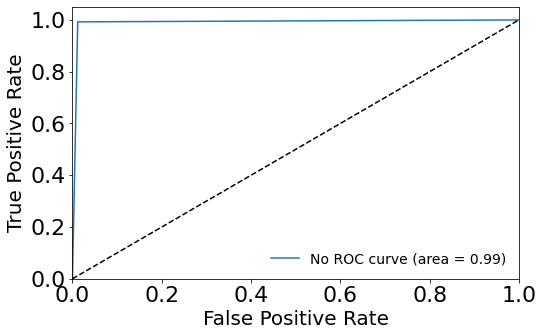

In [18]:
plt.figure(figsize=(8, 5))
for i in range(lb.classes_.size-1):
    plt.plot(fpr[i], tpr[i], 
             label='%s ROC curve (area = %0.2f)' % (lb.classes_.tolist()[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

1- roc curve conferma l'accuracy del modello proposto 

In [0]:
from sklearn.model_selection import cross_val_score

In [20]:
scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.9751 (+/- 0.08)
F1-score: 0.9593 (+/- 0.15)


1- effettuo la cross validation sul modello generato 

2- effettuo la cross validation sul modello generato privato del campo light

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [0]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [23]:
param_list = {'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1, 5, 10, 20],
             }

grid_search = GridSearchCV(clf, param_grid=param_list)
grid_search.fit(X, y)
clf = grid_search.best_estimator_

report(grid_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.989 (std: 0.009)
Parameters: {'min_samples_leaf': 5, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.989 (std: 0.009)
Parameters: {'min_samples_leaf': 5, 'min_samples_split': 5}

Model with rank: 1
Mean validation score: 0.989 (std: 0.009)
Parameters: {'min_samples_leaf': 5, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.989 (std: 0.009)
Parameters: {'min_samples_leaf': 5, 'min_samples_split': 20}

Model with rank: 1
Mean validation score: 0.989 (std: 0.009)
Parameters: {'min_samples_leaf': 10, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.989 (std: 0.009)
Parameters: {'min_samples_leaf': 10, 'min_samples_split': 5}

Model with rank: 1
Mean validation score: 0.989 (std: 0.009)
Parameters: {'min_samples_leaf': 10, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.989 (std: 0.009)
Parameters: {'min_samples_leaf': 10, 'min_samples_split': 20}



In [24]:
param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
             }

random_search = RandomizedSearchCV(clf, param_distributions=param_list, 
                                   n_iter=300)
random_search.fit(X, y)
clf = random_search.best_estimator_

report(random_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.989 (std: 0.009)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 2}

Model with rank: 1
Mean validation score: 0.989 (std: 0.009)
Parameters: {'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 2}

Model with rank: 1
Mean validation score: 0.989 (std: 0.009)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 2}



1- effettuando un'analisi grid search e random search sono stati ottenuti i parametri ottimali dell'albero di decisione, con una profondità di 2, un numero minimo di campioni per lo split pari a 2 ed un numero minimo di campioni per foglia pari a 10. 

2- senza campo light i parametri migliori sono rispettivamente 50,20,4. generando un albero sostanzialmente ridotto e comprensibile

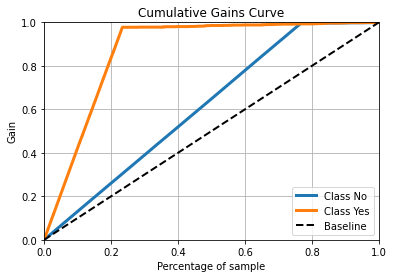

In [25]:
from sklearn.datasets import load_breast_cancer

#X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, 

test_size=0.33)

clf = DecisionTreeClassifier(criterion='gini', max_depth=None, 
                             min_samples_split=2, min_samples_leaf=1)
clf.fit(X_train, y_train)

predicted_probas = clf.predict_proba(X_test)

# The magic happens here

import matplotlib.pyplot as plt

import scikitplot as skplt

skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)

plt.show()

1- il primo lift chart fa notare come il guadagno rispetto all'assenza di un modello sia consistente, in quanto per la classe 0 ci si attesta intorno al 60% del dataset per la classificazione di tutti i record. 